## Modelisation with UNET Mini

In [1]:
import sys  
sys.path.insert(0, './scripts')

# Import librairies, configs, helper functions
from helpers import *

config = base_config

# config["use_saved_model_path"] = "./model_delete.keras"
# config["val_sample_nb"] = 100
# config["train_sample_nb"] = 400
config["max_evals"] = 10
config["mlwflow_experiment_title"] = "UNET VGG16 - Augmented"

n = NotebookProcessor(config)

{
    "width": 512,
    "height": 256,
    "classes": 8,
    "use_augment": true,
    "image_per_augment": 1,
    "max_evals": 10,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET VGG16 - Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


## Model definition

This model adopts the UNet architecture utilizing VGG16 pretrained on ImageNet as its encoder for advanced feature extraction. 

The contracting path is powered by VGG16, capturing in-depth image details, while the expansive path ensures precise localization by upsampling. Skip connections between VGG16's layers and the decoder maintain spatial information. The integration of VGG16 enriches the model's ability to handle complex image segmentation tasks efficiently.  

Here we start at 64 filters all the way to 512 and back to 64

## Model creation

In [2]:
def conv_block(input_tensor, num_filters, dropout_rate=0.1):  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    x = Dropout(dropout_rate)(x)  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    return x  
  
def create_model(n_classes, img_width, img_height, img_channels):    
    # Load VGG16 as the encoder with pretrained ImageNet weights  
    base_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, img_channels))  
      
    # Freeze the layers of VGG16  
    for layer in base_vgg16.layers:  
        layer.trainable = False  
      
    # Encoder - take the outputs of the VGG16 layers to create the contracting path  
    s1 = base_vgg16.get_layer("block1_conv2").output  # 64 filters  
    s2 = base_vgg16.get_layer("block2_conv2").output  # 128 filters  
    s3 = base_vgg16.get_layer("block3_conv3").output  # 256 filters  
    s4 = base_vgg16.get_layer("block4_conv3").output  # 512 filters  
    c5 = base_vgg16.get_layer("block5_conv3").output  # 512 filters, this acts as the bridge  
  
    # Start from bottom and go up, using U-Net's expansive path  
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)    
    u6 = concatenate([u6, s4])    
    c6 = conv_block(u6, 512)   
      
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)    
    u7 = concatenate([u7, s3])    
    c7 = conv_block(u7, 256)    
      
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)    
    u8 = concatenate([u8, s2])    
    c8 = conv_block(u8, 128)    
      
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)    
    u9 = concatenate([u9, s1])    
    c9 = conv_block(u9, 64)    
  
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)    
      
    model = Model(inputs=[base_vgg16.input], outputs=[outputs])  
      
    return model  

## Model Stats

### With augment

2024-02-29 21:58:25.402065: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-29 21:58:25.402086: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-29 21:58:25.402089: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-29 21:58:25.402139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-29 21:58:25.402306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


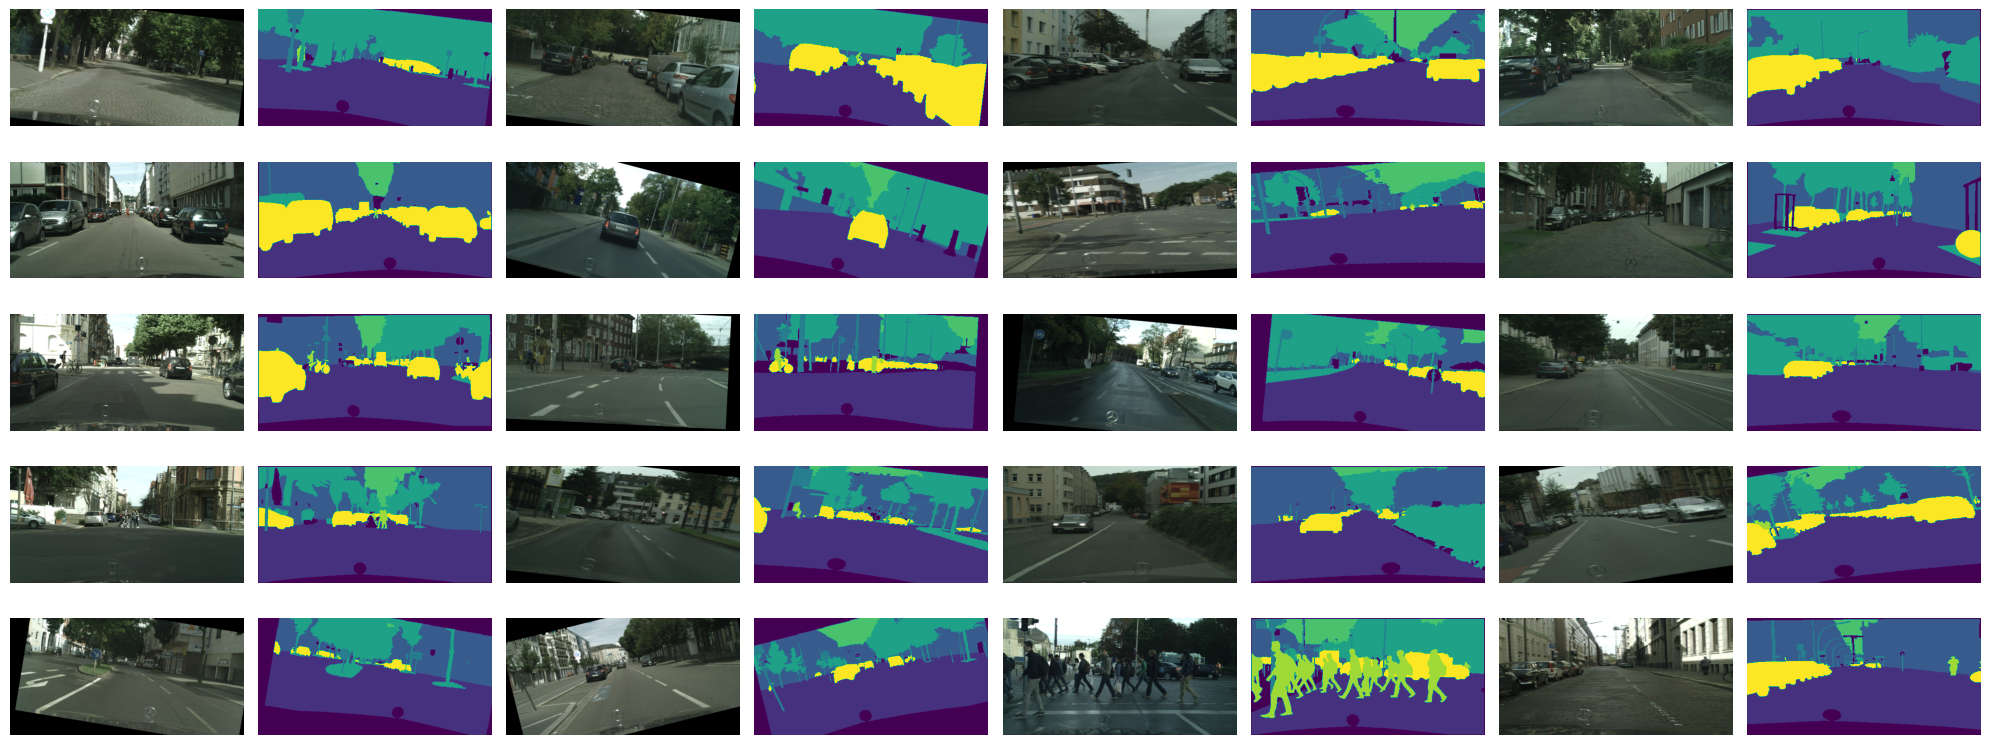

In [3]:
show_data_generator_images_sample(n)

In [4]:
model = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n.set_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 512, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 256, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [5]:
space = None
# space = {
#     'image_per_augment': hp.choice('image_per_augment', [1, 2, 3]),
#     'batch_size': hp.choice('batch_size', [3, 4, 5]),
#     'epochs': hp.choice('epochs', [4, 8, 12, 24]),
#     'learning_rate': hp.uniform('learning_rate', 0.0001, 0.001),  
# }
n.model_fit(space)

Epoch 1/12                                            

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024-02-29 21:58:32.517970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


991/991 [==============================] - 965s 972ms/step - loss: 0.5094 - dice_coef: 0.7640 - iou: 0.6258 - accuracy: 0.8407 - val_loss: 0.5999 - val_dice_coef: 0.7313 - val_iou: 0.5857 - val_accuracy: 0.8015

Epoch 2/12                                            

991/991 [==============================] - 891s 899ms/step - loss: 0.3951 - dice_coef: 0.8122 - iou: 0.6888 - accuracy: 0.8745 - val_loss: 0.5537 - val_dice_coef: 0.7325 - val_iou: 0.5831 - val_accuracy: 0.8183

Epoch 3/12                                            

991/991 [==============================] - 893s 901ms/step - loss: 0.3623 - dice_coef: 0.8271 - iou: 0.7100 - accuracy: 0.8846 - val_loss: 0.4619 - val_dice_coef: 0.7854 - val_iou: 0.6533 - val_accuracy: 0.8501

Epoch 4/12                                            

991/991 [==============================] - 956s 965ms/step - loss: 0.3430 - dice_coef: 0.8358 - iou: 0.7226 - accuracy: 0.8906 - val_loss: 0.4701 - val_dice_coef: 0.8112 - val_iou: 0.6909 - val_ac

In [ ]:
display_loss_and_accuracy(n.model_fit_history)
n.model_predict_with_display_and_accuracy(n.img["val"][0],n.mask["val"][0])

### Without augment

In [ ]:
config_not_aug = {
    **config,
    "use_augment": False,
    "mlwflow_experiment_title":"UNET VGG16 - Not Augmented"

}

n_not_aug = NotebookProcessor(config_not_aug)
show_data_generator_images_sample(n_not_aug)

In [ ]:
model_not_aug = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n_not_aug.set_model(model_not_aug)

In [ ]:

n_not_aug.model_fit(space)


In [ ]:
display_loss_and_accuracy(n_not_aug.model_fit_history)
n_not_aug.model_predict_with_display_and_accuracy(n_not_aug.img["test"][1],n_not_aug.mask["test"][1])

### Performance comparaison augmented vs not

In [ ]:
evaluate_with_and_without_aug(n, n_not_aug)

## Model Inference

In [ ]:
n.model_inference_with_display(n.img["test"][3])

In [ ]:
n_not_aug.model_inference_with_display(n_not_aug.img["test"][3])